<font size="4">**18. Loading and Inspecting African Shapefile Data**</font>

This section demonstrates the process of loading geographic data using GeoPandas, a Python library designed for working with geospatial data. First, the path to the shapefile containing African country boundaries (Africa.shp) is specified. Shapefiles are a common format for storing geographic and attribute data and are widely used in spatial analysis. The gpd.read_file() function is then employed to load the shapefile into a GeoDataFrame, which extends the functionality of a Pandas DataFrame to include spatial data handling.

After loading, the head() method is used to display the first few rows of the GeoDataFrame. This step is crucial for data validation before proceeding to visualization, analysis, or integration with other datasets.

In [3]:
import geopandas as gpd

#path to the shapefile for African countries
africa_shapefile = "./Downloads/Africa/Africa.shp"

#load the shapefile
africa_shape = gpd.read_file(africa_shapefile)

#display the first few rows
print(africa_shape.head())

   fid  OBJECTID F_CODE           NAM NA2       NA2_DESCRI NA3 NA3_DESCRI  \
0    1         1  FA001      DJIBOUTI  DJ         Djibouti   F     Africa   
1    2         2  FA001  ILE TROMELIN  TE  Tromelin Island   F     Africa   
2    3         3  FA001     SWAZILAND  WZ        Swaziland   F     Africa   
3    4         4  FA001          MALI  ML             Mali   F     Africa   
4    5         5  FA001         NIGER  NG            Niger   F     Africa   

           AREA    PERIMETER              WBFPATHLK  ClipNumber  Shape_Leng  \
0  2.176142e+10   870895.471  factbook\geos\dj.html          10    7.964138   
1  1.402880e+06     4509.955  factbook\geos\te.html          15    0.042313   
2  1.732061e+10   544395.759  factbook\geos\wz.html          17    5.128563   
3  1.255648e+12  7441437.730  factbook\geos\ml.html          19   68.770302   
4  1.187627e+12  5743758.001  factbook\geos\ng.html          20   52.596974   

   Shape_Area                                           geomet

<font size="4">**19. Extracting and Aggregating Rainfall Data Using Zonal Statistics**</font>

This section calculates the mean rainfall for each African country from a series of geospatial TIFF files containing normalized rainfall data. It begins by specifying the directory containing the .tif files and sorting them for processing. Each TIFF file is opened using rasterio, and the filename is parsed to extract the corresponding year and month. These temporal attributes are crucial for associating the rainfall data with specific time periods. The zonal_stats function from the rasterstats library is then used to compute the mean rainfall values for the geometries defined in the africa_shape GeoDataFrame. This function integrates the raster data (TIFF files) with vector data (shapefile geometries) to perform spatial analysis.

The script iterates through the zonal statistics for each country in the shapefile and appends the results, including the country name, year, month, and mean rainfall, into a list. This list is then converted into a Pandas DataFrame for tabular representation and saved as a CSV file (aggregated_rainfall_data.csv). This approach efficiently organizes rainfall data by country and time period, enabling further analysis or modeling for tasks such as climate studies or disaster prediction.

In [5]:
from rasterstats import zonal_stats
import pandas as pd
import os
import rasterio

#path to the folder containing the .tif files
tif_folder = "./Downloads/normalized/"
tif_files = sorted([os.path.join(tif_folder, f) for f in os.listdir(tif_folder) if f.endswith(".tif")])

#initialize a list to store results
rainfall_data = []

#iterate through each .tif file
for tif_file in tif_files:
    with rasterio.open(tif_file) as src:
        #extract year and month from the filename (customize based on your filename format)
        year = tif_file.split('.')[-3][-4:]  # Example: Extract 1981
        month = tif_file.split('.')[-2]     # Example: Extract 01, 02, etc.
        
        #calculate zonal statistics (mean rainfall for each country)
        stats = zonal_stats(
            africa_shape,                   # Geometries of the countries
            tif_file,                       # Path to the .tif file
            affine=src.transform,           # Transformation info
            stats=["mean"],                 # Calculate the mean rainfall
            nodata=src.nodatavals[0],       # Exclude no-data values
            geojson_out=False               # Return results as a list of dictionaries
        )
        
        # Add data for each country
        for i, stat in enumerate(stats):
            country = africa_shape.iloc[i]["NAM"]  # Replace "NAME" with your country name column
            mean_rainfall = stat["mean"]           # Extract the mean rainfall value
            
            rainfall_data.append({
                "Country": country,
                "Year": int(year),
                "Month": int(month),
                "Rainfall": mean_rainfall
            })

#convert the results into a DataFrame
rainfall_df = pd.DataFrame(rainfall_data)

#save the extracted data to a CSV file for future use
rainfall_df.to_csv("./Downloads/aggregated_rainfall_data.csv", index=False)

print("Rainfall data saved to aggregated_rainfall_data.csv")

Rainfall data saved to aggregated_rainfall_data.csv


<font size="4">**20. Verify the Extracted Data**</font>

In [7]:
rainfall_df.head(5)

,Country,Year,Month,Rainfall
0,DJIBOUTI,1981,1,0.000452
1,ILE TROMELIN,1981,1,NaN
2,SWAZILAND,1981,1,0.023881
3,MALI,1981,1,0.004452
4,NIGER,1981,1,0.007719


In [8]:
print(rainfall_df.isnull().sum())

Country          0
Year             0
Month            0
Rainfall    297190
dtype: int64


In [9]:
print(rainfall_df.describe())

                Year          Month      Rainfall
count  383980.000000  383980.000000  86790.000000
mean     2002.418251       6.480989      0.022689
std        12.653033       3.444654      0.058645
min      1981.000000       1.000000      0.000000
25%      1991.000000       3.000000      0.000015
50%      2002.000000       6.000000      0.001283
75%      2013.000000       9.000000      0.008231
max      2024.000000      12.000000      0.712813


<font size="4">**21. Exploratory Data Analysis**</font>

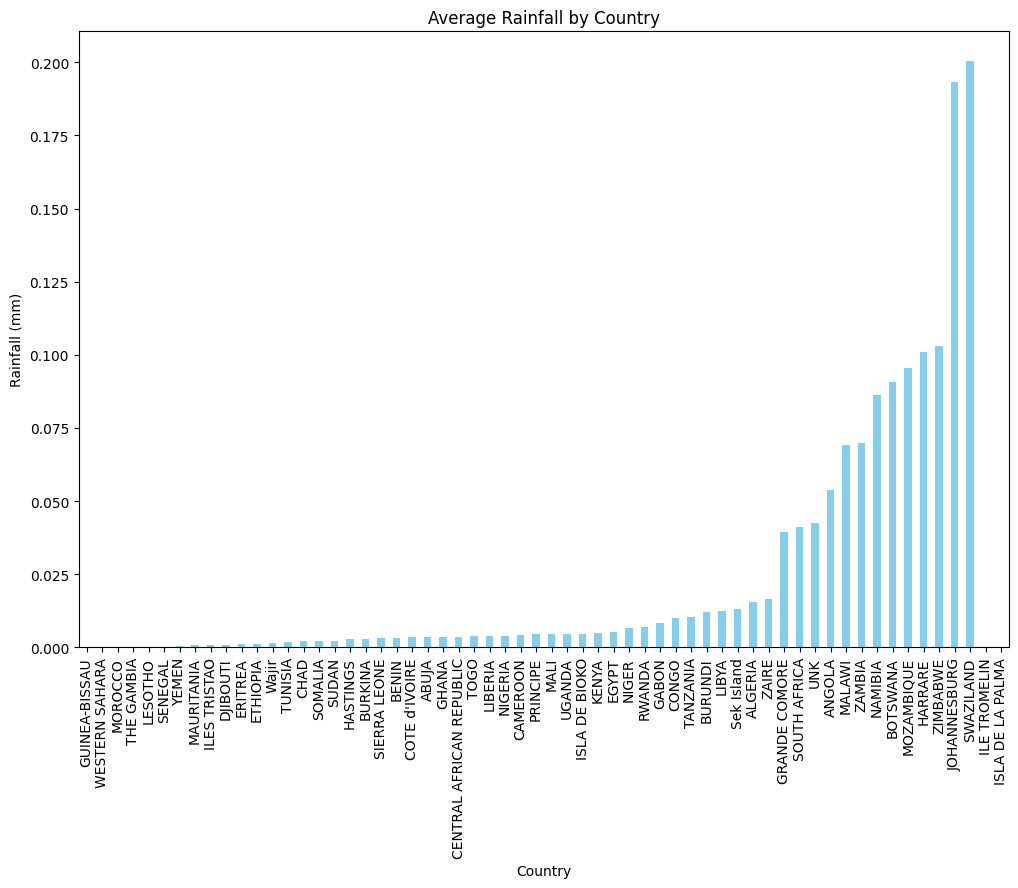

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

#aggregate rainfall by country
avg_rainfall = rainfall_df.groupby("Country")["Rainfall"].mean().sort_values()

#plot average rainfall for each country
plt.figure(figsize=(12, 8))
avg_rainfall.plot(kind="bar", color="skyblue")
plt.title("Average Rainfall by Country")
plt.xlabel("Country")
plt.ylabel("Rainfall (mm)")
plt.xticks(rotation=90)
plt.show()

<font size="4">**22. Impute Missing Values**</font>

In [13]:
rainfall_df["Rainfall"] = rainfall_df["Rainfall"].interpolate()

<font size="4">**23. Filter Outliers**</font>

This section applies the Interquartile Range (IQR) method to detect and remove outliers in the rainfall data. First, the first (Q1) and third (Q3) quartiles of the Rainfall column are calculated, representing the 25th and 75th percentiles, respectively. The IQR, defined as the difference between Q3 and Q1, provides a measure of the spread of the middle 50% of the data. Outliers are defined as data points that fall below the lower bound (Q1 - 1.5 * IQR) or above the upper bound (Q3 + 1.5 * IQR).

To ensure data quality, the rainfall dataset is filtered to include only values within the acceptable range, effectively removing extreme values that could distort analysis or modeling. This step is particularly important for ensuring the reliability of statistical summaries and predictive models that rely on this dataset. By addressing outliers, the dataset becomes more representative of typical rainfall patterns across African countries.

In [15]:
Q1 = rainfall_df["Rainfall"].quantile(0.25)
Q3 = rainfall_df["Rainfall"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

rainfall_df = rainfall_df[(rainfall_df["Rainfall"] >= lower_bound) & (rainfall_df["Rainfall"] <= upper_bound)]

<font size="4">**24. Verify Missing Values are Handled**</font>

In [17]:
#confirm there are no remaining missing values
if rainfall_df.isnull().sum().sum() == 0:
    print("No missing values remain in the dataset.")
else:
    print("There are still missing values that need to be addressed.")

No missing values remain in the dataset.


In [18]:
#save the cleaned dataset to a CSV file
rainfall_df.to_csv("./Downloads/final_rainfall_data.csv", index=False)
print("Final dataset saved to final_rainfall_data.csv")

Final dataset saved to final_rainfall_data.csv
